In [1]:
from SimpleCV import *
from IPython.display import HTML
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import glob

toevoegingen

- matrix misschien veranderen naar/toevoegen: hoeveel pixels in stukje zwart
- blob.contours -- aantal hoeken

In [2]:
disp = Display(displaytype='notebook')
size = 32

imagelist = []
horizontalSplit=[]

# get all files and add them to tuple with the postal codes
for filename in glob.glob("../dataset-images/*.png"): 
    originalImage = Image(filename)
    image = originalImage.binarize().dilate().erode()
    invertedImage = image.invert().embiggen( (128,40), Color.WHITE, (3,3))
    answer = filename[18:22]
    imagelist.append((answer, image, invertedImage))

numbers = []
   
for image in imagelist:
    for i in range(4):
        sizeHeight = 40
        sizeWidth = 32
        digit = image[0][(0 if i+1 == 1 else i):i+1]
        normalImage = image[1].crop(i*size, 0, size, size*(i+1))
        invertedImage = image[2].crop(i*sizeWidth, 0, sizeWidth, sizeHeight*(i+1))
        numbers.append((digit, normalImage, invertedImage))

In [3]:
# divide number images into pieces of 4x4 and create matrix
def createMatrix(image):
    size = 8
    m = np.zeros((4,4))

    pieces = []
    for y in range(4):
        for x in range(4):
            crop = image.crop(x*size, y*size, size, size)
            pieces.append(crop)
            m[x][y] = 1 if crop.meanColor()[0] > 80 else 0
    return m.T

In [4]:
# check if centroid pixel is black. If black return 1 else 0 
def isCentroidPixelBlack(image, centroid):
    img = image.crop(centroid[0], centroid[1], 1, 1)
    color = img.meanColor()
    return 0 if color[0] > 200 else 1

In [5]:
# get the blob from the image
def getBlob(image):
    image.show()
    blobs = image.findBlobs()
    image.draw(blobs, autocolor=True)
    return blobs[0]

def splitImage(image, centroidY, height):    
    croppedImageTop = image.crop(0,0,height,centroidY)
    blobTop = getBlob(croppedImageTop)
    centroidTop = blobTop.centroid()
    pixelBlackTop = isCentroidPixelBlack(croppedImageTop,centroidTop)
    
    croppedImageBottom = image.crop(0,centroidY, height,(height-centroidY))   
    blobBottom = getBlob(croppedImageBottom)
    centroidBottom = blobBottom.centroid()
    pixelBlackBottom = isCentroidPixelBlack(croppedImageBottom,centroidBottom)

    return (pixelBlackTop, pixelBlackBottom)


########### move to analysis ######## 
def createHeatMap(image):
    size = 8
    m = np.zeros((4,4))
    pieces = []
    for y in range(4):
        for x in range(4):
            crop = image.crop(x*size, y*size, size, size)
            pieces.append(crop)
            m[x][y] = crop.meanColor()[0]
    plt.imshow(m.T, cmap='Blues', interpolation='nearest')
    plt.show()

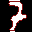

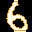

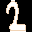

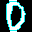

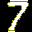

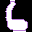

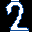

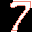

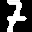

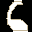

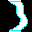

KeyboardInterrupt: 

In [6]:
numbersDict = {
    "grid_1_1": [],
    "grid_1_2": [],
    "grid_1_3": [],
    "grid_1_4": [],
    "grid_2_1": [],
    "grid_2_2": [],
    "grid_2_3": [],
    "grid_2_4": [],
    "grid_3_1": [],
    "grid_3_2": [],
    "grid_3_3": [],
    "grid_3_4": [],
    "grid_4_1": [],
    "grid_4_2": [],
    "grid_4_3": [],
    "grid_4_4": [],
    "blob_area" : [],
    "blob_centroid_x" : [],
    "blob_centroid_y" : [],
    "blob_angle" : [],
    "blob_height": [],
    "blob_width": [],
    "number_of_holes":[],
    "centroid_is_empty": [],
    "centroid_top_is_empty":[],
    "centroid_bottom_is_empty":[],
    "label" : []
}
    
for number in numbers:
    digit = number[0]
    image = number[1]
    invertedImage = number[2]
    invertedBlobCount = len(invertedImage.findBlobs()) -1
    blob = getBlob(image)
    matrix = createMatrix(image)
    centroid = blob.centroid()
    split = splitImage(image, centroid[1], blob.height())
    image.save(disp)
    for y in range(4):
        for x in range(4):
            numbersDict["grid_" + str(y+1) + "_" + str(x +1)].append(matrix[y][x])

    
#     numbersDict["matrix_top_row"].append(sum(matrix[0]))
#     numbersDict["matrix_second_row"].append(sum(matrix[1]))
#     numbersDict["matrix_third_row"].append(sum(matrix[2]))
#     numbersDict["matrix_bottom_row"].append(sum(matrix[3]))
    numbersDict["blob_area"].append(blob.area())
    numbersDict["blob_centroid_x"].append(centroid[0])
    numbersDict["blob_centroid_y"].append(centroid[1])
    numbersDict["blob_angle"].append(blob.angle())
    numbersDict["blob_height"].append(blob.height())
    numbersDict["blob_width"].append(blob.width())
    numbersDict["number_of_holes"].append(invertedBlobCount)
    numbersDict["centroid_is_empty"].append(isCentroidPixelBlack(image, centroid))
    numbersDict["centroid_top_is_empty"].append(split[0])
    numbersDict["centroid_bottom_is_empty"].append(split[1])
    numbersDict["label"].append(number[0])    

df = pd.DataFrame(numbersDict)
df = df[[
#         "matrix_top_row", 
#          "matrix_second_row", 
#          "matrix_third_row", 
#          "matrix_bottom_row", 
        "grid_1_1",
        "grid_1_2",
        "grid_1_3",
        "grid_1_4",
        "grid_2_1",
        "grid_2_2",
        "grid_2_3",
        "grid_2_4",
        "grid_3_1",
        "grid_3_2",
        "grid_3_3",
        "grid_3_4",
        "grid_4_1",
        "grid_4_2",
        "grid_4_3",
        "grid_4_4",
         "blob_area", 
         "blob_centroid_x", 
         "blob_centroid_y",
         "blob_angle",
         "blob_height",
         "blob_width",
         "number_of_holes",
         "centroid_is_empty",
         "centroid_top_is_empty",
         "centroid_bottom_is_empty",
         "label"]]
df = df.sort_values("label")

In [ ]:
# TEST : 4686: too many blobs

# testImage = Image("../dataset-images/4686.png")
# testImage = testImage.binarize().dilate().erode()
# blobs = testImage.findBlobs()
# testImage.draw(blobs, autocolor=True)
# testImage.save(disp)
# print blobs.area()

# testNums = []

# for i in range(4):
#     testNums.append(testImage.crop(i*size, 0, size, size*(i+1) ))

In [ ]:
df.to_csv("../dataset-numpy/dataset_features.csv", sep=',', encoding='utf-8', index=False)

In [ ]:
#####move to feature analysis ####

df.describe()

In [ ]:
# #list with tuples (digit, invertbloblength, counter) 
# ['0', 1, 4]
# ['0', 2, 173]
# ['1', 1, 198]
# ['2', 1, 193]
# ['2', 2, 2]
# ['3', 1, 194]
# ['3', 2, 5]
# ['4', 1, 171]
# ['4', 2, 14]
# ['5', 1, 184]
# ['5', 2, 3]
# ['6', 1, 60]
# ['6', 2, 135]
# ['7', 1, 196]
# ['7', 2, 3]
# ['8', 1, 27]
# ['8', 2, 62]
# ['8', 3, 91]
# ['9', 1, 60]
# ['9', 2, 144]

# ['0', 0, 4], 
# ['0', 1, 173], 
# ['1', 0, 198], 
# ['2', 0, 193],
# ['2', 1, 2]
# ['3', 0, 194],
# ['3', 1, 5],
# ['4', 1, 15], 
# ['4', 0, 171], 
# ['5', 0, 184], 
# ['5', 1, 3], 
# ['6', 1, 135], 
# ['6', 0, 60],
# ['7', 0, 196],
# ['7', 1, 3], 
# ['8', 0, 27],
# ['8', 1, 53],
# ['8', 2, 91], 
# ['9', 0, 60], 
# ['9', 1, 144], 
  


20

In [ ]:
# #### naar feature analysis verplaatsen #######

# show labels with the holes and amount
df.groupby(['label', 'number_of_holes']).size()